In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 5]

%matplotlib notebook
%matplotlib notebook

In [ ]:
# Estava tentando ler o codigo, mas acabei usando o que vc passou

# df_2015 = pd.read_csv('./ISONewEngland_2015-2018/2015_smd_hourly_ISONE CA_fixed.csv')
# df_2015_data = df_2015[['SYSLoad']]
# df_2015_date = df_2015[['DATE']]

# df_2016 = pd.read_csv('./ISONewEngland_2015-2018/2016_smd_hourly_ISONE CA_fixed.csv')
# df_2016_data = df_2016[['SYSLoad']]
# df_2016_date = df_2016[['DATE']]

# df_2017 = pd.read_csv('./ISONewEngland_2015-2018/2017_smd_hourly_ISONE CA_fixed.csv')
# df_2017_data = df_2017[['SYSLoad']]
# df_2017_date = df_2017[['DATE']]

# df_2018 = pd.read_csv('./ISONewEngland_2015-2018/2018_smd_hourly_ISONE CA_fixed.csv')
# df_2018_data = df_2018[['SYSLoad']]
# df_2018_date = df_2018[['DATE']]

# df_data = pd.DataFrame(pd.concat([df_2015_data, df_2016_data, df_2017_data, df_2018_data])).reset_index(drop = True)
# df_date = pd.concat([df_2015_date, df_2016_date, df_2017_date, df_2018_date]).reset_index(drop = True)

# df = pd.DataFrame()
# df['Date'] = df_date
# df['Data'] = df_data['SYSLoad']

In [2]:
import glob 
def datasetImport(selectDatasets, dataset_name='ISONewEngland'):
    print('Dataset import has been started')
    # Save all files in the folder
    if dataset_name.find('ONS') != -1:
        filename = glob.glob(path + r'/datasets/ONS/*south*.csv')
        filename = filename[0].replace('\\','/')
        dataset = pd.read_csv(filename,index_col=None, header=0, delimiter=";")
        # Select only selected data
        datasetList = []
        for year in selectDatasets:
            datasetList.append(dataset[dataset['DATE'].str.find(year) != -1])
    elif dataset_name.find('ISONewEngland') != -1:
        all_files = glob.glob('./ISONewEngland_2015-2018/*.csv')
        # Initialize dataset list
        datasetList = []
        # Read all csv files and concat them
        for filename in all_files:
            if (filename.find("ISONE") != -1):
                for data in selectDatasets:
                    if (filename.find(data) != -1):
                        df = pd.read_csv(filename,index_col=None, header=0)
                        datasetList.append(df)
    # Concat them all
    dataset = pd.concat(datasetList, axis=0, sort=False, ignore_index=True)
    
    if dataset_name.find('ONS') != -1:
        # replace comma to dot
        dataset['DEMAND'] = dataset['DEMAND'].str.replace(',','.')
        dataset['DATE'] = pd.to_datetime(dataset.DATE, format="%d/%m/%Y %H:%M")
        dataset = dataset.sort_values(by='DATE', ascending=True)
    
    dataset = dataset.iloc[:-24*60,:]
    return dataset

def dataCleaning(dataset, dataset_name='ISONewEngland'):
    print('Data cleaning function has been started')
    # Select X data
    X = dataset.iloc[:, :]
    if dataset_name.find('ONS') != -1:
        X = X.drop(['DEMAND'], axis=1)
    elif dataset_name.find('ISONewEngland') != -1:
        try:
            X = X.drop(['DEMAND','DA_DEMD','DA_LMP','DA_EC','DA_CC','DA_MLC','DATE','HOUR','RT_LMP','RT_EC','RT_CC','RT_MLC','SYSLoad','RegSP','RegCP'], axis=1)
        except KeyError:
            X = X.drop(['DEMAND','DA_DEMD','DA_LMP','DA_EC','DA_CC','DA_MLC','DATE','HOUR','RT_LMP','RT_EC','RT_CC','RT_MLC','SYSLoad'], axis=1)
        # Drop additional unused columns/features
        for columnNames in X.columns:
            if(columnNames.find("5min") != -1):
                X.drop([columnNames], axis=1, inplace=True)
    ## Pre-processing input data 
    # Verify zero values in dataset (X,y)
    print("Any null value in dataset?")
    print(dataset.isnull().any())
    print("How many are they?")
    print(dataset.isnull().sum())
    print("How many zero values?")
    print(dataset.eq(0).sum())
    print("How many zero values in y (DEMAND)?")
    print(dataset['DEMAND'].eq(0).sum())

    # Set y
    y = dataset['DEMAND'].astype(float)

    # Taking care of missing data
    print('Taking care of missing data')
    if (dataset['DEMAND'].eq(0).sum() > 0
        or dataset['DEMAND'].isnull().any()):    
        print(dataset[dataset['DEMAND'].isnull()])
        # Save the NaN indexes
        nanIndex = dataset[dataset['DEMAND'].isnull()].index.values
        # Replace zero values by NaN
        dataset['DEMAND'].replace(0, np.nan, inplace=True)
        #convert to float
        y = dataset['DEMAND'].astype(float)
        y = y.interpolate(method='linear', axis=0).ffill().bfill()
        print(y.iloc[nanIndex])

    # Select Y data
    if dataset_name.find('ONS') != -1:
        y = pd.concat([pd.DataFrame({'DEMAND':y}), dataset['SUBSYSTEM']], axis=1, sort=False)

    return X, y


def featureEngineering(dataset, X, selectDatasets, weekday=False, holiday=False, holiday_bridge=False,  dataset_name='ISONewEngland'):
    print('Feature engineering has been started')
    # Decouple date and time from dataset
    # Then concat the decoupled date in different columns in X data


    print("Adding date components (year, month, day, holidays and weekdays) to input data")
    # Transform to date type
    X['DATE'] = pd.to_datetime(dataset.DATE)
    # X['DATE'] = pd.to_datetime(dataset.DATE, format="%d/%m/%Y %H:%M")

    date = X['DATE']
    Year = pd.DataFrame({'Year':date.dt.year})
    Month = pd.DataFrame({'Month':date.dt.month})
    Day = pd.DataFrame({'Day':date.dt.day})
    Hour = pd.DataFrame({'HOUR':date.dt.hour})

    if weekday:
        # Add weekday to X data
        Weekday = pd.DataFrame({'Weekday':date.dt.dayofweek})

    if holiday:
        # Add holidays to X data
        br_holidays = []
        for date2 in holidays.Brazil(years=list(map(int,selectDatasets))).items():
            br_holidays.append(str(date2[0]))

        # Set 1 or 0 for Holiday, when compared between date and br_holidays
        Holiday = pd.DataFrame({'Holiday':[1 if str(val).split()[0] in br_holidays else 0 for val in date]})

    
    # Concat all new features into X data
    try: 
        concatlist = [X,Year,Month,Day,Weekday,Hour,Holiday]
    except (AttributeError, ValueError, KeyError, UnboundLocalError) as e:
        concatlist = [X,Year,Month,Day,Hour]
    X = pd.concat(concatlist,axis=1)

    # Split X data to different subsystems/regions
    # Xs = X[X['SUBSYSTEM'].str.find("South") != -1].reset_index(drop=True)
    # Xs = Xs.drop(['SUBSYSTEM','DATE'],axis=1)

    # Save in Date format
    global df  # set a global variable for easier plot
    if dataset_name.find('ONS') != -1:
        # df = X[X['SUBSYSTEM'].str.find("All") != -1]['DATE'].reset_index(drop=True)
        df = X['DATE'].reset_index(drop=True)
    elif dataset_name.find('ISONewEngland') != -1:
        df = X['DATE'].reset_index(drop=True)


    X_all = []
    y_all = []
    
    if holiday_bridge:
        print("Adding bridge days (Mondays / Fridays) to the Holiday column")
        # Holidays on Tuesdays and Thursday may have a bridge day (long weekend)
        # X_tmp = X_all[0][(X_all[0]['Holiday'] > 0).values].drop_duplicates(subset=['Day','Month','Year'])
        X_tmp = X[(X['Holiday'] > 0).values]
        # Filter holidays set on Tuesdays and add bridge day on Mondays
        # 0 = Monday; 1 = Tuesday; ...; 6 = Sunday
        # Start with Tuesdays
        X_tuesdays = X_tmp[X_tmp['Weekday'] == 1]
        bridgeDayList = []
        for tuesday in X_tuesdays['DATE']:
            # Go back one day (monday)
            bridge_day = tuesday - pd.DateOffset(days=1)
            bridgeDayList.append(bridge_day)

        # Do the same for Thursday
        X_thursdays = X_tmp[X_tmp['Weekday'] == 3]
        for thursday in X_thursdays['DATE']:
            # Go back one day (Friday)
            bridge_day = thursday + pd.DateOffset(days=1)
            bridgeDayList.append(bridge_day)
        
            
        Holiday_bridge = pd.DataFrame({'Holiday_bridge':[1 if val in bridgeDayList else 0 for val in date]})


        concatlist = [X,Holiday_bridge]
        X = pd.concat(concatlist,axis=1)

        # Sum the two holidays columns to merge them into one and remove unnecessary columns
        X['Holiday_&_bridge']=X.loc[:,['Holiday','Holiday_bridge']].sum(axis=1)
        X = X.drop(['Holiday','Holiday_bridge'], axis=1)

    if dataset_name.find('ONS') != -1:       
        # Store regions in a list of dataframes
        print('Organize and split input data by different regions')
        unique = X['SUBSYSTEM'].unique()

        for region in unique:
            X_temp = X[X['SUBSYSTEM']==region].reset_index(drop=True)
            X_all.append(X_temp)
            y_temp = y[y['SUBSYSTEM']==region].reset_index(drop=True)
            y_all.append(y_temp)
    
    elif dataset_name.find('ISONewEngland') != -1:
        X_all.append(X)
        y_all.append(y)

    return X_all, y_all

# Dataset chosen
DATASET_NAME = 'ISONewEngland'
selectDatasets = ["2015","2016","2017","2018"]
# Dataset import 
dataset = datasetImport(selectDatasets, dataset_name=DATASET_NAME)
# Data cleaning and set the input and reference data
X, y = dataCleaning(dataset, dataset_name=DATASET_NAME)
# Include new data 
X_all, y_all = featureEngineering(dataset, X, selectDatasets, dataset_name=DATASET_NAME)    

Dataset import has been started
Data cleaning function has been started
Any null value in dataset?
DATE            False
HOUR            False
DA_DEMD         False
DEMAND           True
DA_LMP          False
DA_EC           False
DA_CC           False
DA_MLC          False
RT_LMP          False
RT_EC           False
RT_CC           False
RT_MLC          False
DRYBULB         False
DEWPNT          False
SYSLoad         False
RegCP           False
RegSP            True
Min_5min_RSP     True
Max_5min_RSP     True
Min_5min_RCP     True
Max_5min_RCP     True
dtype: bool
How many are they?
DATE                0
HOUR                0
DA_DEMD             0
DEMAND              2
DA_LMP              0
DA_EC               0
DA_CC               0
DA_MLC              0
RT_LMP              0
RT_EC               0
RT_CC               0
RT_MLC              0
DRYBULB             0
DEWPNT              0
SYSLoad             0
RegCP               0
RegSP           17520
Min_5min_RSP    67224
Max_5min_RSP

In [3]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error


def input_output( Z, n_lags, horizon):
    X = np.zeros((0, 1))
    Y = np.zeros((0, 1))
    for sample in range(n_lags, np.size(Z, 0) - horizon):
        X = np.concatenate([X, Z[sample - n_lags:sample]])
        Y = np.concatenate([Y, Z[sample + 1:sample + 1 + horizon]])
    return X, Y


x_training, y_training = input_output(y_all[0][0:288].to_numpy().reshape(-1,1), 1, 1)
x_test, y_test = input_output(y_all[0][289:360].to_numpy().reshape(-1,1), 1, 1)

model = XGBRegressor(objective='reg:squarederror', max_depth=2)
model.fit(x_training, y_training)
prediction = model.predict(x_test)
mse = np.sqrt(mean_squared_log_error(y_test, prediction))
mse


0.1027990290334526

<IPython.core.display.Javascript object>


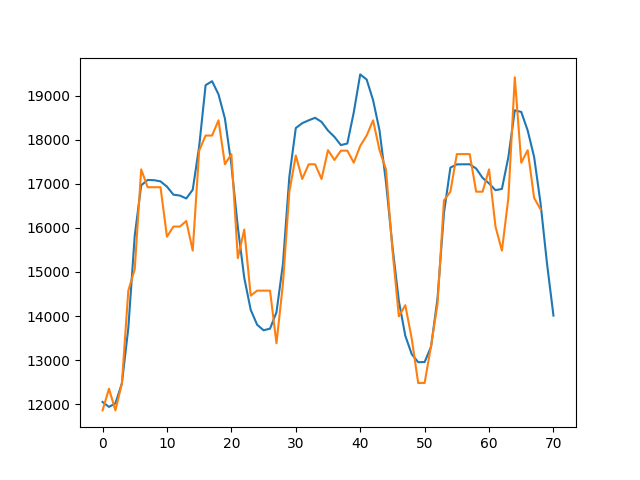

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

max_value = y_all[0].max()
y_norm = y_all[0] / max_value

y, y_lambda = stats.boxcox(y_all[0])

plt.plot(y_all[0][289:360].reset_index(drop = True))
plt.plot(prediction)

plt.show()